tmp# World Data League 2021
## Notebook Template

This notebook is one of the mandatory deliverables when you submit your solution (alongside the video pitch). Its structure follows the WDL evaluation criteria and it has dedicated cells where you can add descriptions. Make sure your code is readable as it will be the only technical support the jury will have to evaluate your work.

The notebook must:

*   💻 have all the code that you want the jury to evaluate
*   🧱 follow the predefined structure
*   📄 have markdown descriptions where you find necessary
*   👀 be saved with all the output that you want the jury to see
*   🏃‍♂️ be runnable


## Authors
Write the name (first and last) of the people on your team that are responsible for developing this solution.

## External links and resources
Paste here all the links to external resources that are necessary to understand and run your code. Add descriptions to make it clear how to use them during evaluation.

## Introduction
Describe how you framed the challenge by telling us what problem are you trying to solve and how your solution solves that problem.

## Development
Start coding here! 👩‍💻

Don't hesitate to create markdown cells to include descriptions of your work where you see fit, as well as commenting your code.

We know that you know exactly where to start when it comes to crunching data and building models, but don't forget that WDL is all about social impact...so take that into consideration as well.

In [1]:
# Imports
import os
import glob
import math
import numpy as np
import pandas as pd
import pylab
import seaborn as sns
import holidays
import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Helper functions

def dbmean(levels, axis=None):
    """
    Energetic average of levels in decibels (such as audio).
    :param levels: Sequence of levels.
    :param axis: Axis over which to perform the operation.
    .. math:: L_{mean} = 10 \\log_{10}{\\frac{1}{n}\\sum_{i=0}^n{10^{L/10}}}
    """
    return 10.0 * np.log10((10.0**(levels / 10.0)).mean(axis=axis))

it_holidays = holidays.CountryHoliday('Italy')

## Data Loading

Loads:
- the list of sensors (from 2016 to 2019
- Acoustic zone mapping  for each sensor (dB limit in day and night)
- Businesses within 500 m radius
- Complaints data, which then filtered out to San Salvario, in the locations where we have sensors

In [3]:
# Load sensor list

sensor_list = pd.read_csv('data/noise_sensor_list.csv', sep = ';')
sensor_list['Sensor_ID'] = ['C1', 'C2', 'C3', 'C4', 'C5']
sensor_list['Lat'] = sensor_list['Lat'].str.replace(',', '.').astype(float)
sensor_list['Long'] = sensor_list['Long'].str.replace(',', '.').astype(float)

# Get mapping locations and correspondence to area type
# Link: https://webgis.arpa.piemonte.it/Geoviewer2D/?config=other-configs/acustica_config.json

mapping_location_area_code = pd.DataFrame(
    [['s_01', 65, 55, 'IV - Aree di intensa attività umana'],
    ['s_02', 60, 50, 'III - Aree di tipo misto'],
    ['s_03', 60, 50, 'III - Aree di tipo misto'],
    ['s_05', 65, 55, 'IV - Aree di intensa attività umana'],
    ['s_06', 60, 50, 'III - Aree di tipo misto']],
    columns=['code', 'day_max_db', 'night_max_db', 'area_type']
)

sensor_list = sensor_list.merge(mapping_location_area_code, on=['code'])

# Load businesses within 500 m radius
businesses_within_500m_radius = pd.read_csv('data/pois_per_sensor/thresh_df_0.5.csv', sep=';')
sensor_list = sensor_list.merge(businesses_within_500m_radius, on=['Sensor_ID'])

In [4]:
businesses_within_500m_radius

,Sensor_ID,Abbigliamento,Alimentari,Alimentari annessi ad altra attivita,Articoli per animali,Articoli pr la casa,Articoli sanitari e ortopedici,Audiovisivi,Autoveicoli e motoveicoli,Bibite,...,Pizza al taglio,Profumeria,Quotidiani e periodici,Ricambi auto e accessori,Sexy shop,Tabacchi,Telefonia,Tessuti,Vendita al dettaglio di cose antiche ed usate,Vendita non esclusiva di giornali
0,C1,37,52,5,3,3,0,11,4,22,...,6,10,5,1,1,8,15,1,12,1
1,C2,37,54,5,3,3,1,11,4,22,...,6,11,5,1,1,8,15,1,13,1
2,C3,37,53,5,3,3,1,11,4,22,...,6,11,5,1,1,8,15,1,12,1
3,C4,37,54,5,3,3,1,11,4,22,...,6,11,5,1,1,8,15,1,13,1
4,C5,26,37,3,3,2,1,7,2,17,...,4,10,5,1,1,6,9,1,9,1


In [5]:
sensor_list.head(3)

,code,address,Lat,Long,streaming,Sensor_ID,day_max_db,night_max_db,area_type,Abbigliamento,...,Pizza al taglio,Profumeria,Quotidiani e periodici,Ricambi auto e accessori,Sexy shop,Tabacchi,Telefonia,Tessuti,Vendita al dettaglio di cose antiche ed usate,Vendita non esclusiva di giornali
0,s_01,"Via Saluzzo, 26 Torino",45.059172,7.678986,https://userportal.smartdatanet.it/userportal/...,C1,65,55,IV - Aree di intensa attività umana,37,...,6,10,5,1,1,8,15,1,12,1
1,s_02,"Via Principe Tommaso, 18bis Torino",45.057837,7.681555,https://userportal.smartdatanet.it/userportal/...,C2,60,50,III - Aree di tipo misto,37,...,6,11,5,1,1,8,15,1,13,1
2,s_03,Largo Saluzzo Torino,45.058518,7.678854,https://userportal.smartdatanet.it/userportal/...,C3,60,50,III - Aree di tipo misto,37,...,6,11,5,1,1,8,15,1,12,1


In [6]:
def load_noise_data(file_paths, sensor_list):
    """
    Function for loading noise data into the correct format
    """
    concat_data = []
    for file in file_paths:
        df = pd.read_csv(file, header=8, sep=';')
        df = df.melt(id_vars=['Data', 'Ora'])
        df['Timestamp'] = pd.to_datetime(df['Data'] + ' ' + df['Ora'])
        df.columns = ['Date', 'Time', 'Sensor_ID', 'Intensity', 'Timestamp']
        df['Intensity'] = df['Intensity'].str.replace(',', '.').astype(float)

        concat_data.append(df)

    concat_df = pd.concat(concat_data)

    output = concat_df.merge(sensor_list, on=['Sensor_ID'])
    
    return output

file_paths_noise_data = [
    'data/noise_data/san_salvario_2016.csv',
    'data/noise_data/san_salvario_2017.csv',
    'data/noise_data/san_salvario_2018.csv',
    'data/noise_data/san_salvario_2019.csv',
]
df_noise = load_noise_data(file_paths_noise_data, sensor_list)

In [7]:
df_noise.head(3)

,Date,Time,Sensor_ID,Intensity,Timestamp,code,address,Lat,Long,streaming,...,Pizza al taglio,Profumeria,Quotidiani e periodici,Ricambi auto e accessori,Sexy shop,Tabacchi,Telefonia,Tessuti,Vendita al dettaglio di cose antiche ed usate,Vendita non esclusiva di giornali
0,01-06-2016,00:00,C1,61.1,2016-01-06 00:00:00,s_01,"Via Saluzzo, 26 Torino",45.059172,7.678986,https://userportal.smartdatanet.it/userportal/...,...,6,10,5,1,1,8,15,1,12,1
1,01-06-2016,01:00,C1,57.2,2016-01-06 01:00:00,s_01,"Via Saluzzo, 26 Torino",45.059172,7.678986,https://userportal.smartdatanet.it/userportal/...,...,6,10,5,1,1,8,15,1,12,1
2,01-06-2016,02:00,C1,52.5,2016-01-06 02:00:00,s_01,"Via Saluzzo, 26 Torino",45.059172,7.678986,https://userportal.smartdatanet.it/userportal/...,...,6,10,5,1,1,8,15,1,12,1


In [8]:
# Load police complaints data

file_paths = glob.glob('data/police_complaints/*.csv')

def load_police_complaints(file_paths):
    """
    Load and filter data related with police complaints for a specific district (San salvario)
    """
    concat_data = []
    for file in file_paths:
        df = pd.read_csv(file, sep=',')
        df['Timestamp'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
        concat_data.append(df)
    df_final = pd.concat(concat_data)

    filter = ['Facilities disturbances', 'Disturbing noises', 'Youth aggregation']
    df_filtered = df_final.loc[df_final['Criminal sub-category'].isin(filter)]

    # Filter data within San Salvario and neighbourhood:
    # http://aperto.comune.torino.it/dataset/circoscrizioni
    df_filtered_san_salvario = df_filtered[df_filtered.District == 8]

    df_filtered_san_salvario.loc[:, 'Localization'] = df_filtered_san_salvario.loc[:, 'Localization'].str.lower().str.strip()

    # Map the locations in df_filtered_san_salvario to the sensor addresses in the noise sensor dataset
    localization_address_mapping = {
       'principe tommaso/(via)':  'Via Principe Tommaso, 18bis Torino',
       'baretti/giuseppe (via)': 'Via Principe Tommaso angolo via Baretti Torino',
       'marconi/guglielmo (corso)' : 'Corso Marconi, 27 Torino',
       'saluzzo/(largo)': 'Largo Saluzzo Torino',
       'saluzzo/(via)': 'Via Saluzzo, 26 Torino'
    }

    df_filtered_san_salvario.loc[:, 'address'] = df_filtered_san_salvario.loc[:, 'Localization'].map(localization_address_mapping)
    
    # Return the cases we can map to our sensors
    df_filtered_san_salvario = df_filtered_san_salvario[~df_filtered_san_salvario['address'].isna()]

    return df_filtered_san_salvario

In [9]:
df_filtered_san_salvario = load_police_complaints(file_paths)

In [10]:
# Load weather data

def load_weather_data(data_path, date_col, value_cols, agg_operation = 'mean'):
    """
    Function to load data and to get it by columns of interess and aggregation operation
    """
    print("Reading file ", data_path)
    
    if data_path == 'data\weather\weather_3.csv':
        header_to_ignore=5
    else:
        header_to_ignore=4
    
    df = pd.read_csv(data_path, header=header_to_ignore, sep=';')

    df['Timestamp'] = pd.to_datetime(df['Date'] + ' ' + df['Hour'])

    df = df.drop_duplicates()
    
    df[value_cols].fillna(0)
    df[value_cols] = df[value_cols].str.replace(',', '.').astype(float)
    
    df_resampled = df.set_index(date_col)[value_cols].resample('H').agg('mean').reset_index()

    return df_resampled

In [11]:
def weather_data():

    path_rain = 'data\weather\weather_1.csv'
    path_wind = 'data\weather\weather_2.csv'
    path_temperature = 'data\weather\weather_3.csv'
    path_wind_gust = 'data\weather\weather_4.csv'

    df_rain = load_weather_data(path_rain, 'Timestamp', 'C1')
    df_wind = load_weather_data(path_wind, 'Timestamp', 'C1')
    df_temperature = load_weather_data(path_temperature, 'Timestamp', 'C2') 
    df_wind_gust = load_weather_data(path_wind_gust, 'Timestamp', 'C1') 
    
    df_rain = df_rain.rename(columns={'C1': 'rain'}, inplace = False)
    df_wind = df_wind.rename(columns={'C1': 'wind'}, inplace = False)
    df_temperature = df_temperature.rename(columns={'C2': 'temperature'}, inplace = False)
    df_wind_gust = df_wind_gust.rename(columns={'C1': 'wind_gust'}, inplace = False)
    
    return df_rain, df_wind, df_temperature, df_wind_gust

load_from_cache = 1

import pickle

if not load_from_cache:
    df_rain, df_wind, df_temperature, df_wind_gust = weather_data()
else:
    paths = [
        'data/weather/processed/df_wind.pkl', 
        'data/weather/processed/df_temperature.pkl', 
        'data/weather/processed/df_rain.pkl',
        'data/weather/processed/df_wind_gust.pkl',
    ]
    for path in paths:
        print("Loading file ", path)
        with (open(path, "rb")) as f:
            df_weather = pickle.load(f)
            df_noise = df_noise.merge(df_weather, on=['Timestamp'])


Loading file  data/weather/processed/df_wind.pkl
Loading file  data/weather/processed/df_temperature.pkl
Loading file  data/weather/processed/df_rain.pkl
Loading file  data/weather/processed/df_wind_gust.pkl


In [12]:
df_noise.head(3)

,Date,Time,Sensor_ID,Intensity,Timestamp,code,address,Lat,Long,streaming,...,Sexy shop,Tabacchi,Telefonia,Tessuti,Vendita al dettaglio di cose antiche ed usate,Vendita non esclusiva di giornali,wind,temperature,rain,wind_gust
0,01-06-2016,00:00,C1,61.1,2016-01-06,s_01,"Via Saluzzo, 26 Torino",45.059172,7.678986,https://userportal.smartdatanet.it/userportal/...,...,1,8,15,1,12,1,0.7,14.2,0.0,NaN
1,01-06-2016,00:00,C2,58.8,2016-01-06,s_02,"Via Principe Tommaso, 18bis Torino",45.057837,7.681555,https://userportal.smartdatanet.it/userportal/...,...,1,8,15,1,13,1,0.7,14.2,0.0,NaN
2,01-06-2016,00:00,C3,63.7,2016-01-06,s_03,Largo Saluzzo Torino,45.058518,7.678854,https://userportal.smartdatanet.it/userportal/...,...,1,8,15,1,12,1,0.7,14.2,0.0,NaN


# Exploratory Data Analysis

### Sensor Location

TODO: Description here about the sensors' proximity

In [13]:
import folium

m = folium.Map(location=[45.0530, 7.6798], zoom_start=15)

for indice, row in sensor_list.iterrows():
    folium.Marker(
        location=[row["Lat"], row["Long"]],
        popup=row['address'],
        icon=folium.Icon(color="red", icon='volume-up', prefix='fa')
        ).add_to(m)

m

### Complaints distribution

TODO: Write description with conclusions

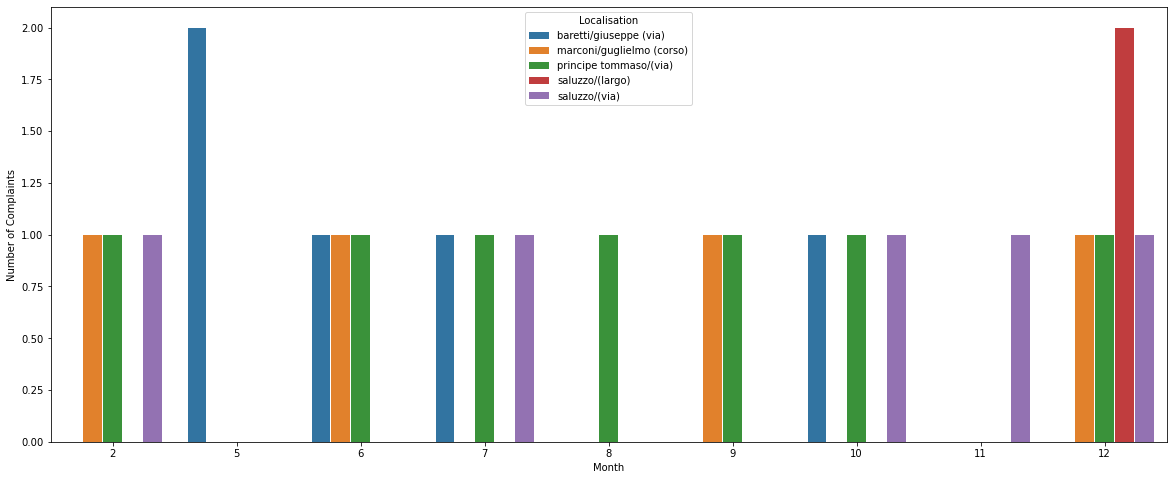

In [14]:
df_filtered_san_salvario['Month'] = pd.DatetimeIndex(df_filtered_san_salvario['Timestamp']).month
df_filtered_san_salvario['Number of Complaints'] = 1
df_grouped_san_salvario = df_filtered_san_salvario.groupby(['Localization', 'Month']).sum().reset_index()
df_grouped_san_salvario = df_grouped_san_salvario.copy()[["Localization", "Month", "Number of Complaints"]]

fig, ax = pylab.subplots(figsize=(20, 8))

sns.barplot(data=df_grouped_san_salvario, ax=ax, x="Month", y="Number of Complaints", hue="Localization")

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

change_width(ax, .15)
pylab.legend(loc='upper center', title="Localisation")
pylab.show()

## Typical Sensor Behavior

Per hour of the day, on all days

In [15]:
avg_intensity_per_hour = df_noise[df_noise.Sensor_ID == 'C1'].groupby(df_noise.Timestamp.dt.hour)['Intensity'].apply(dbmean)

Text(0.5, 0, 'Hour of day (h)')

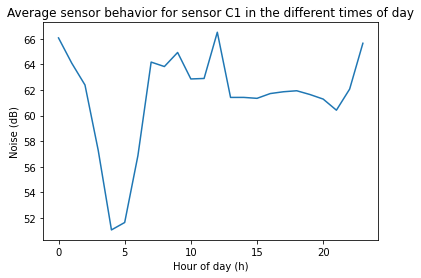

In [16]:
import matplotlib.pyplot as plt

plt.plot(np.arange(len(avg_intensity_per_hour)), avg_intensity_per_hour.values)
plt.title('Average sensor behavior for sensor C1 in the different times of day')
plt.ylabel('Noise (dB)')
plt.xlabel('Hour of day (h)')

## Feature Extraction and Target Creation

In [17]:
def get_date_features(df_resampled, date_col, suffix, holidays_list):
    """
    Function for getting date features from a datetime column, based on Pandas DataSeries predefined functions. 
    """
    df_resampled[f'day_{suffix}'] = df_resampled[date_col].dt.day
    df_resampled[f'hour_{suffix}'] = df_resampled[date_col].dt.hour
    df_resampled[f'month_{suffix}'] = df_resampled[date_col].dt.month
    df_resampled[f'dayofweek_{suffix}'] = df_resampled[date_col].dt.dayofweek
    df_resampled[f'is_holiday_{suffix}'] = df_resampled[date_col].apply(lambda x: x in holidays_list)
    df_resampled[f'is_weekend_{suffix}'] = np.where(df_resampled[f'dayofweek_{suffix}'].isin([5, 6]), 1, 0)
                                                  
    return df_resampled

df_noise = get_date_features(df_noise, date_col='Timestamp', suffix='now', holidays_list=it_holidays)

In [18]:
df_noise.head(3)

,Date,Time,Sensor_ID,Intensity,Timestamp,code,address,Lat,Long,streaming,...,wind,temperature,rain,wind_gust,day_now,hour_now,month_now,dayofweek_now,is_holiday_now,is_weekend_now
0,01-06-2016,00:00,C1,61.1,2016-01-06,s_01,"Via Saluzzo, 26 Torino",45.059172,7.678986,https://userportal.smartdatanet.it/userportal/...,...,0.7,14.2,0.0,NaN,6,0,1,2,True,0
1,01-06-2016,00:00,C2,58.8,2016-01-06,s_02,"Via Principe Tommaso, 18bis Torino",45.057837,7.681555,https://userportal.smartdatanet.it/userportal/...,...,0.7,14.2,0.0,NaN,6,0,1,2,True,0
2,01-06-2016,00:00,C3,63.7,2016-01-06,s_03,Largo Saluzzo Torino,45.058518,7.678854,https://userportal.smartdatanet.it/userportal/...,...,0.7,14.2,0.0,NaN,6,0,1,2,True,0


Extract noise-related features:
- Threshold: Does the current noise level exceed the limit (at day or night?)
- Relative difference between intensity and current maximum intensity

In [19]:
def current_db(data, date_col='hour_now'):
    """
    Function for determining the current legal limit
    """
    mask_day = (data[date_col] > 6) & (data[date_col] < 22) 
    mask_night = (data[date_col] > 22) | (data[date_col] < 6)
    mask = mask_day | mask_night
    data['current_max_db_value'] = np.where(mask==mask_day, data[f'day_max_db'], data[f'night_max_db'])
    
    return data

def noise_threshold(data, date_col='hour_now', suffix='now', value_col='Intensity'):
    """
    Function for determining if noise exceeds legal threshold
    """
    mask_day = (data[date_col] > 6) & (data[date_col] < 22) & (data[value_col] > data['day_max_db'])
    mask_night = (data[date_col] > 22) | (data[date_col] < 6) & (data[value_col] > data['night_max_db'])
    mask = mask_day | mask_night

    data[f'noise_exceeds_threshold_{suffix}'] = np.where(mask, 1, 0)
    
    return data

# Relative difference between intensity and current maximum intensity
df_noise = current_db(df_noise, date_col='hour_now')
df_noise['relative_diff_intensity_max_db'] = (df_noise.Intensity - df_noise.current_max_db_value) / df_noise.Intensity

# Threshold: Does the current noise level exceed the limit (at day or night?)
df_noise = noise_threshold(df_noise, date_col='hour_now', suffix='now', value_col='Intensity')

In [20]:
df_noise[['Timestamp', 'Intensity', 'noise_exceeds_threshold_now', 'current_max_db_value']].tail(5)

,Timestamp,Intensity,noise_exceeds_threshold_now,current_max_db_value
157075,2019-12-31 23:00:00,60.5,1,55
157076,2019-12-31 23:00:00,63.2,1,50
157077,2019-12-31 23:00:00,65.8,1,50
157078,2019-12-31 23:00:00,NaN,1,55
157079,2019-12-31 23:00:00,NaN,1,50


Determine current legal limit and how close the intensity is to it, as a feature

## Target Creation

In [21]:
def create_target_noise_level(df_resampled, date_col = 'Timestamp', target_col = 'Intensity', entity_id='Sensor_ID', date_offset = 24):
    """
    Function from creating lagged or future features for a specific date offset.
    For instance, this adds a new column with the intensity values 24 hours in the future, for each row, by default.    
    """
    
    df_resampled[f'date_col_{target_col}'] = df_resampled[date_col] + pd.DateOffset(hours=date_offset)
    tmp = df_resampled[[entity_id, date_col, f'date_col_{target_col}', target_col]].merge(
        df_resampled[[entity_id, date_col, f'date_col_{target_col}', target_col]], 
        left_on = [entity_id, f'date_col_{target_col}'], 
        right_on=[entity_id, date_col], 
        how='left'
    )

    tmp = tmp[[entity_id, f'{date_col}_x', f'{target_col}_y']]
    tmp.columns = [entity_id, date_col, f'target_{target_col}_{str(date_offset)}h']

    df_resampled = df_resampled.merge(tmp, on=[entity_id, date_col])
    
    return df_resampled

In [22]:
# Create our target

df_noise = create_target_noise_level(df_noise, target_col='Intensity', date_offset=24)

# Add date features on target date
# Add noise threshold on the hour of the target
df_noise = get_date_features(df_noise, date_col='date_col_Intensity', suffix='target', holidays_list=it_holidays)
df_noise = noise_threshold(df_noise, date_col='hour_target', suffix='target', value_col='target_Intensity_24h')

In [23]:
df_noise.head(3)

,Date,Time,Sensor_ID,Intensity,Timestamp,code,address,Lat,Long,streaming,...,noise_exceeds_threshold_now,date_col_Intensity,target_Intensity_24h,day_target,hour_target,month_target,dayofweek_target,is_holiday_target,is_weekend_target,noise_exceeds_threshold_target
0,01-06-2016,00:00,C1,61.1,2016-01-06,s_01,"Via Saluzzo, 26 Torino",45.059172,7.678986,https://userportal.smartdatanet.it/userportal/...,...,1,2016-01-07,NaN,7,0,1,3,False,0,0
1,01-06-2016,00:00,C2,58.8,2016-01-06,s_02,"Via Principe Tommaso, 18bis Torino",45.057837,7.681555,https://userportal.smartdatanet.it/userportal/...,...,1,2016-01-07,NaN,7,0,1,3,False,0,0
2,01-06-2016,00:00,C3,63.7,2016-01-06,s_03,Largo Saluzzo Torino,45.058518,7.678854,https://userportal.smartdatanet.it/userportal/...,...,1,2016-01-07,NaN,7,0,1,3,False,0,0


We will now create our target for complaints, following this rule:

- A complaint happened on day 24 (for instance). As some of the rows don't have the complaint date - and we don't know if the complaint date refers to the reporting date or the date of occurence - we consider that the noise could have happened on the 24 or 23.
- As we are predicting one day in advance, we consider as positive labels both 23 and 22. 

In [24]:
df_filtered_san_salvario[
    df_filtered_san_salvario.Timestamp == '2017-06-19'
]

,Criminal category,Criminal sub-category,District,Localization,Green Area,Date,Hour,Timestamp,address,Month,Number of Complaints
689,Civil coexistence,Disturbing noises,8.0,baretti/giuseppe (via),NaN,19/06/2017,NaN,2017-06-19,Via Principe Tommaso angolo via Baretti Torino,6,1


In [25]:
df_noise['Timestamp_trunc'] = df_noise['Timestamp'].dt.floor('d')

"""
def create_target_complaints_new(df_filtered_san_salvario, df_noise, range_days = 2, target_forecast = 1):

    tmp = df_filtered_san_salvario.merge(df_noise, on=['address'])

    tmp['Timestamp_x'] = pd.to_datetime(tmp['Timestamp_x'])
    tmp['Timestamp_y'] = pd.to_datetime(tmp['Timestamp_y']) - pd.Timedelta(target_forecast, 'd')

    tmp['day_difference'] = (tmp['Timestamp_x'] - tmp['Timestamp_y']).dt.days

    complaints = tmp[(tmp.day_difference > 0) & (tmp.day_difference < range_days)][['address', 'Timestamp_trunc']].drop_duplicates(['address', 'Timestamp_trunc'])
    complaints['complaint_followed'] = 1

    merged = df_noise.merge(
        complaints, 
        on=['address', 'Timestamp_trunc'], 
        how='left'
    )
    merged['complaint_followed'] = np.where(merged['complaint_followed'].isna(), 0, 1)
    
    return merged, complaints
"""

"\ndef create_target_complaints_new(df_filtered_san_salvario, df_noise, range_days = 2, target_forecast = 1):\n\n    tmp = df_filtered_san_salvario.merge(df_noise, on=['address'])\n\n    tmp['Timestamp_x'] = pd.to_datetime(tmp['Timestamp_x'])\n    tmp['Timestamp_y'] = pd.to_datetime(tmp['Timestamp_y']) - pd.Timedelta(target_forecast, 'd')\n\n    tmp['day_difference'] = (tmp['Timestamp_x'] - tmp['Timestamp_y']).dt.days\n\n    complaints = tmp[(tmp.day_difference > 0) & (tmp.day_difference < range_days)][['address', 'Timestamp_trunc']].drop_duplicates(['address', 'Timestamp_trunc'])\n    complaints['complaint_followed'] = 1\n\n    merged = df_noise.merge(\n        complaints, \n        on=['address', 'Timestamp_trunc'], \n        how='left'\n    )\n    merged['complaint_followed'] = np.where(merged['complaint_followed'].isna(), 0, 1)\n    \n    return merged, complaints\n"

In [26]:
def create_target_complaints(df_filtered_san_salvario, range_days = 2, target_forecast = 1):
    """
    Creates target for complaints
    """
    df_filtered_san_salvario['Date'] = pd.to_datetime(df_filtered_san_salvario['Date'])
    complaints = df_filtered_san_salvario[['Date', 'address']].drop_duplicates()

    # Target dates: same day or subtract one day (by default)
    range_deltas = [pd.Timedelta(x + 1, 'd') for x in np.arange(0, 2)]

    target_dfs = []
    for x in range_deltas:
        complaints_copy = complaints.copy()
        complaints_copy['target_date'] = complaints_copy['Date'] - x

        target_dfs.append(complaints_copy)

    target_df_final = pd.concat(target_dfs)
    target_df_final['complaint_followed'] = 1
    target_df_final = target_df_final.rename(columns={'Date': 'complaint_date'})
    return target_df_final

In [61]:
complaints_list = create_target_complaints(df_filtered_san_salvario)

In [62]:
complaints_list[complaints_list.complaint_date == '2017-06-19']

,complaint_date,address,target_date,complaint_followed
689,2017-06-19,Via Principe Tommaso angolo via Baretti Torino,2017-06-18,1
689,2017-06-19,Via Principe Tommaso angolo via Baretti Torino,2017-06-17,1


In [29]:
df_noise = df_noise.merge(target_df_final, left_on=['Timestamp_trunc', 'address'], right_on=['target_date', 'address'], how='left')

In [30]:
# Add our target to the noise measurements dataframe

df_noise['complaint_followed'] = df_noise['complaint_followed'].fillna(0).astype(int)

In [31]:
df_noise[df_noise.complaint_followed == 1].head(3)

,Date,Time,Sensor_ID,Intensity,Timestamp,code,address,Lat,Long,streaming,...,hour_target,month_target,dayofweek_target,is_holiday_target,is_weekend_target,noise_exceeds_threshold_target,Timestamp_trunc,complaint_date,target_date,complaint_followed
1681,15-06-2016,00:00,C2,60.3,2016-06-15 00:00:00,s_02,"Via Principe Tommaso, 18bis Torino",45.057837,7.681555,https://userportal.smartdatanet.it/userportal/...,...,0,6,3,False,0,1,2016-06-15,2016-06-17,2016-06-15,1
1686,15-06-2016,01:00,C2,57.2,2016-06-15 01:00:00,s_02,"Via Principe Tommaso, 18bis Torino",45.057837,7.681555,https://userportal.smartdatanet.it/userportal/...,...,1,6,3,False,0,1,2016-06-15,2016-06-17,2016-06-15,1
1691,15-06-2016,02:00,C2,55.1,2016-06-15 02:00:00,s_02,"Via Principe Tommaso, 18bis Torino",45.057837,7.681555,https://userportal.smartdatanet.it/userportal/...,...,2,6,3,False,0,1,2016-06-15,2016-06-17,2016-06-15,1


In [60]:
df_noise[df_noise.complaint_followed == 1].Timestamp_trunc.unique()

array(['2016-05-10T00:00:00.000000000', '2016-05-11T00:00:00.000000000',
       '2016-06-15T00:00:00.000000000', '2016-06-16T00:00:00.000000000',
       '2016-09-17T00:00:00.000000000', '2016-09-18T00:00:00.000000000',
       '2016-09-30T00:00:00.000000000', '2016-10-10T00:00:00.000000000',
       '2016-10-11T00:00:00.000000000', '2016-12-17T00:00:00.000000000',
       '2016-12-18T00:00:00.000000000', '2017-06-17T00:00:00.000000000',
       '2017-06-18T00:00:00.000000000', '2017-07-17T00:00:00.000000000',
       '2017-07-18T00:00:00.000000000', '2017-10-05T00:00:00.000000000',
       '2017-10-06T00:00:00.000000000', '2017-10-27T00:00:00.000000000',
       '2017-10-28T00:00:00.000000000', '2017-12-31T00:00:00.000000000',
       '2018-01-01T00:00:00.000000000', '2018-06-21T00:00:00.000000000',
       '2018-06-22T00:00:00.000000000', '2018-09-06T00:00:00.000000000',
       '2018-09-07T00:00:00.000000000', '2018-11-05T00:00:00.000000000',
       '2018-11-06T00:00:00.000000000', '2019-03-08

# Model Training

In [42]:
# We create a list of columns that we do not need to train our model
COLS_TO_REMOVE = [
    'Timestamp',
    'Sensor_ID',
    'address',
    'Lat',
    'Long',
    'area_type',
    'target_Intensity_24h',
    'date_col_Intensity',
    'noise_exceeds_threshold_target',
    'Timestamp_trunc',
    'complaint_followed',
    'code',
    'streaming',
    'target_date',
    'complaint_date',
    'Date',
    'Time'
    #'average_intensity_next_3h',
    #'noise_exceeds_threshold_target_2'
]

# Based on the previous list, we create a new list with the features that we actually need!
COLS_TO_KEEP = [x for x in df_noise.columns if x not in COLS_TO_REMOVE]

In [43]:
COLS_TO_KEEP

['Intensity',
 'day_max_db',
 'night_max_db',
 'Abbigliamento',
 'Alimentari',
 'Alimentari annessi ad altra attivita',
 'Articoli per animali',
 'Articoli pr la casa',
 'Articoli sanitari e ortopedici',
 'Audiovisivi',
 'Autoveicoli e motoveicoli',
 'Bibite',
 'Bigiotteria',
 'Calzature',
 'Carburanti',
 'Cartolerie',
 'Casalinghi - Igiene casa e persona',
 'Elettrodomestici e/o ricambi',
 'Elettronica',
 'Enoteca',
 'Erboristeria',
 'Extralimentari',
 'Farmacia',
 'Ferramenta',
 'Fiori e piante',
 'Frutta e verdura',
 'Gastronomia',
 'Gelateria',
 'Giocattoli',
 'Intimo',
 'Librerie',
 'Macelleria',
 'Minimercato',
 'Mista',
 'Mobili',
 'Negozio con apparecchi automatici',
 'Nessuna',
 'Non alimentari annessi ad altre attivita',
 'Non alimentari generici',
 'Oggetti preziosi',
 "Opere d'arte",
 'Ottica',
 'Panetteria',
 'Panificio',
 'Pasticceria',
 'Pescheria',
 'Phone center',
 'Pizza al taglio',
 'Profumeria',
 'Quotidiani e periodici',
 'Ricambi auto e accessori',
 'Sexy shop',
 

In [44]:
"""
# Cross validation for hyperparameter tuning

from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV

tscv = TimeSeriesSplit(n_splits=5)

xgb = XGBRegressor()

params = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': range(3, 10, 2),
    'min_child_weight': range(1,6,2),
    'gamma': [i/10.0 for i in range(0,5)]
}

search = RandomizedSearchCV(xgb, params, cv=tscv, n_iter=10, random_state=42)

search.fit(
    X_train[COLS_TO_KEEP].fillna(9999).astype(float), 
    y_train
)
"""

"\n# Cross validation for hyperparameter tuning\n\nfrom sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV\n\ntscv = TimeSeriesSplit(n_splits=5)\n\nxgb = XGBRegressor()\n\nparams = {\n    'n_estimators': [100, 200, 300, 400],\n    'max_depth': range(3, 10, 2),\n    'min_child_weight': range(1,6,2),\n    'gamma': [i/10.0 for i in range(0,5)]\n}\n\nsearch = RandomizedSearchCV(xgb, params, cv=tscv, n_iter=10, random_state=42)\n\nsearch.fit(\n    X_train[COLS_TO_KEEP].fillna(9999).astype(float), \n    y_train\n)\n"

In [45]:
df_noise = df_noise.sort_values(by= ['Timestamp', 'Sensor_ID']).reset_index(drop=True)

In [46]:
target_1 = 'target_Intensity_24h'

from xgboost import XGBClassifier

# Train model
# Please note that we use 80% of the data set as our train set!
X_train = df_noise[0:int(0.7*len(df_noise))]

# We remove the NaNs (labels that are NaNs)
X_train = X_train[~X_train[target_1].isna()]

# We use the remaining 20% as test set
X_test = df_noise[1 + int(0.7*len(df_noise)):]

# We remove the NaNs (labels that are NaNs)
X_test = X_test[~X_test[target_1].isna()]

# Our labels column
y_train = X_train['noise_exceeds_threshold_target']

# We train an XGBoost Regressor. 
# Since it is a decision tree, it becomes easier to explain the decisions of our model
xgb_noise = XGBClassifier(n_estimators=100)

# We train our model
xgb_noise.fit(X_train[COLS_TO_KEEP].fillna(9999).astype(float), y_train)

y_pred = xgb_noise.predict_proba(X_test[COLS_TO_KEEP].fillna(9999).astype(float))
X_test['pred_score_noise'] = y_pred[:, 1]

[16:55:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [47]:
X_train.Timestamp.max(), X_test.Timestamp.min()

(Timestamp('2018-12-04 07:00:00'), Timestamp('2018-12-04 07:00:00'))

In [48]:
# X_test[(X_test.noise_exceeds_threshold_target == 1)][['Timestamp', 'Sensor_ID', 'Intensity', 'target_Intensity_24h']]

In [49]:
from sklearn.metrics import roc_auc_score

print("ROC AUC", roc_auc_score(X_test['noise_exceeds_threshold_target'], y_pred[:, 1]))

ROC AUC 0.9388956758272708


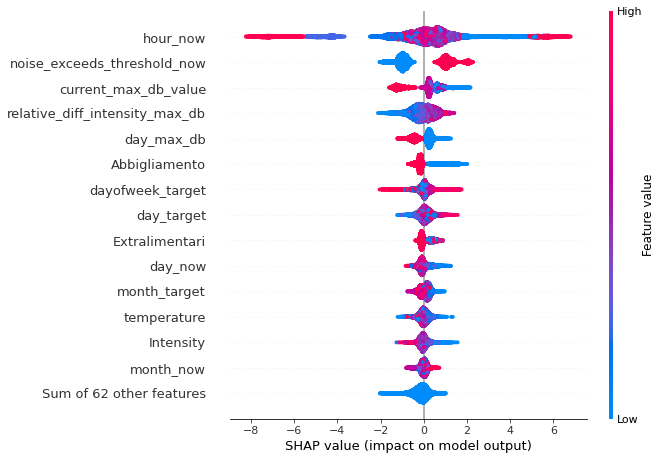

In [50]:
import shap
# Shap explanation

# We now explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(xgb_noise)
shap_values_noise = explainer(X_test[COLS_TO_KEEP].fillna(9999).astype(float))

# Let's get a nice plot with the shap values so you can have an intuition on the rationale behind the model learned by the XGBoost Regressor
shap.plots.beeswarm(shap_values_noise, max_display=15)

In [52]:
target_1 = 'complaint_followed'

from xgboost import XGBClassifier

# Train model
# Please note that we use 80% of the data set as our train set!
X_train = df_noise[0:int(0.7*len(df_noise))]

# We remove the NaNs (labels that are NaNs)
X_train = X_train[~X_train[target_1].isna()]

# We use the remaining 20% as test set
X_test = df_noise[int(0.7*len(df_noise)):]

# We remove the NaNs (labels that are NaNs)
X_test = X_test[~X_test[target_1].isna()]

# Our labels column
y_train = X_train[target_1]

# We train an XGBoost Regressor. 
# Since it is a decision tree, it becomes easier to explain the decisions of our model
xgb_complaint = XGBClassifier(n_estimators=100)

# We train our model
xgb_complaint.fit(X_train[COLS_TO_KEEP].fillna(9999).astype(float), y_train)

y_pred = xgb_complaint.predict_proba(X_test[COLS_TO_KEEP].fillna(9999).astype(float))
X_test['pred_score_complaint'] = y_pred[:, 1]

[16:55:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [64]:
X_test[target_1].isna().sum()

0

In [53]:
print("ROC AUC", roc_auc_score(X_test['complaint_followed'], y_pred[:, 1]))

ROC AUC 0.4219551169510294


In [ ]:
import shap
# Shap explanation

# We now explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(xgb_complaint)
shap_values = explainer(X_test[COLS_TO_KEEP].fillna(9999).astype(float))

In [ ]:
shap.plots.beeswarm(shap_values, max_display=15)

## Decision Process

In [ ]:
X_test = X_test.reset_index(drop=True)
day_to_predict = X_test[X_test.Timestamp == '2018-12-05']

In [ ]:
X_test

In [ ]:
mask = X_test.Timestamp == '2018-12-05'

In [ ]:
shap.initjs()

# TODO: Add for loop for each of the sensor.
# For each, plot the figure and add the text
fig = shap.plots.force(shap_values_noise[mask[mask == True].index[1]])
fig

In [ ]:
fig.data['featureNames'][1], fig.data['features'][1]

# TODO: Create a dict mapping the features to its name written in a less technical way
mapping_dict = {
    'Intensity': 'Measured intensity in dB, at current date:'
}

# "mapping_dict['Intensity'] = 64.3; mapping_dict['day_max_db'] = 60.0"

In [ ]:
# TODO: Write pandas DataFrame with

# prediction_hour
# sensor_id
# probability modelo 1
# probability modelo 2
# explanation modelo 1
# explanation modelo 2

## Conclusions

### Scalability and Impact
Tell us how applicable and scalable your solution is if you were to implement it in a city. Identify possible limitations and measure the potential social impact of your solution.

### Future Work
Now picture the following scenario: imagine you could have access to any type of data that could help you solve this challenge even better. What would that data be and how would it improve your solution? 🚀